## Predicting House Prices

In this project I will try to predict the sale price of houses. Since I am trying to predict a continuous value (sale price) then it means that I am working on a regression problem.

### Dataset

For this Kaggle challenge we have a dataset split into two groups: training set and test set. These sets contain information about the houses but only the training set has the sale price for the houses. The training set has 1460 examples and the test set has 1459 examples.

In total, there are 80 features and the target variable `SalePrice`. In the `Data` folder, we can find a data dictionary for this dataset in the file `data_description.txt`.

### Evaluation metric

The evaluation metric defined by [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) in this competition is the Root Mean Squared Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. Taking the logarithms means that errors in predicting expensive houses and cheap houses will affect the result equally.

#### Importing libraries

In [1]:
# Exploratory Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Fill missing values
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Label Encoding
from sklearn.preprocessing import LabelEncoder

# Box cox transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

#### Load data

In [2]:
# Import training set
df_train = pd.read_csv('Data/train.csv')

# Check dimensions 
df_train.shape

(1460, 81)

In [3]:
# Import test set
df_test = pd.read_csv('Data/test.csv')

# Check dimensions 
df_test.shape

(1459, 80)

In [4]:
# View data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Information about the training set
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# Information about the test set
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

### 1. Exploratory Data Analysis

#### 1.1 Target variable and correlations

I will start by checking the correlation of the target variable `SalePrice` with the features.

In [7]:
# Correlations
corr = df_train.corr()

# View features with biggest correlation with 'SalePrice' 
corr['SalePrice'].sort_values(ascending=False)[:10]

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

I will check the relationship of the variables `OverallQual`, `GrLivArea`, `TotalBsmtSF` and `YearBuilt` with `SalePrice`. These seem the most interesting for me to explore.

**SalePrice and OverallQual**

`OverallQual` rates the overall material and finish of the house.

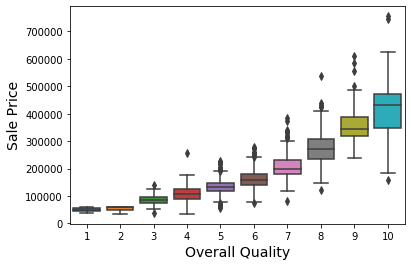

In [8]:
sns.boxplot(df_train['OverallQual'], df_train['SalePrice'])
plt.xlabel('Overall Quality', fontsize=14)
plt.ylabel('Sale Price', fontsize=14);

**SalePrice and GrLivArea**

`GrLivArea` measures the square feet of living area above ground (not counting the basement).

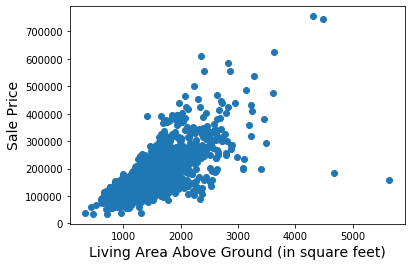

In [9]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.xlabel('Living Area Above Ground (in square feet)', fontsize=14)
plt.ylabel('Sale Price', fontsize=14);

In the right corner of the plot, we can see two values with a quite high `GrLivArea` values but low `SalePrice` values which seems strange. These datapoints are not following the trend at all and so I will remove them given that they are very large outliers.

In [10]:
# Get indices of the two outliers
df_train[df_train['GrLivArea'] > 4500].index

df_train.drop([523, 1298], inplace=True)

**SalePrice and TotalBsmtSF**

`TotalBsmtSF` measures the total square feet of the basement.

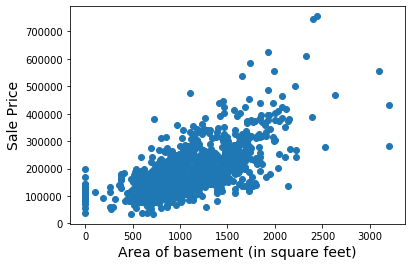

In [11]:
plt.scatter(df_train['TotalBsmtSF'], df_train['SalePrice'])
plt.xlabel('Area of basement (in square feet)', fontsize=14)
plt.ylabel('Sale Price', fontsize=14);

**SalePrice and YearBuilt**

`YearBuilt` indicates the year that the house was built in.

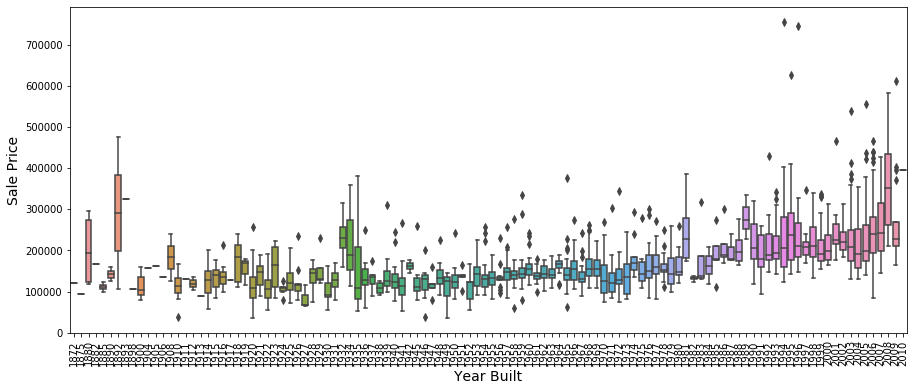

In [12]:
plt.figure(figsize=(15, 6))
sns.boxplot(df_train['YearBuilt'], df_train['SalePrice'])
plt.xticks(rotation=90)
plt.xlabel('Year Built', fontsize=14)
plt.ylabel('Sale Price', fontsize=14);

The correlation here is definitely weaker than with the previous features but it is still noticeable. It makes sense that in general the more recent a house is, the more expensive it will be, given that as time passes by houses will be built with better materials and woth better characteristics.

**Distribution of target variable**

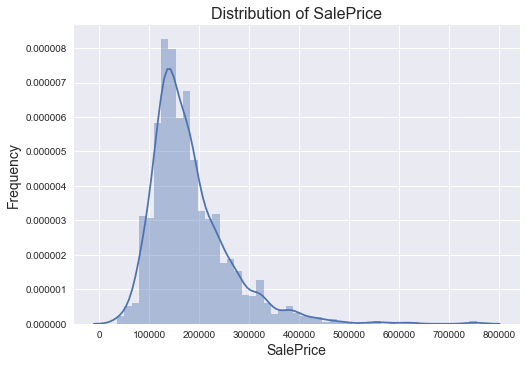

In [13]:
plt.style.use('seaborn')
sns.distplot(df_train['SalePrice'])
plt.xlabel('SalePrice', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of SalePrice', fontsize=16);

The target variable is right skewed. As (linear) models work better with normally distributed data and the evaluation metric for this project is the RMSE between the logarithm of the predicted values and the actual values, I will transform this variable with log(1 + x) and make it more normally distributed.

The reason for using log(1 + x) instead of log(x) is that it is accurate also for values x so small that 1 + x == 1 in floating-point accuracy. It also helps dodge errors if values for some columns are 0, as log(0) returns -inf.

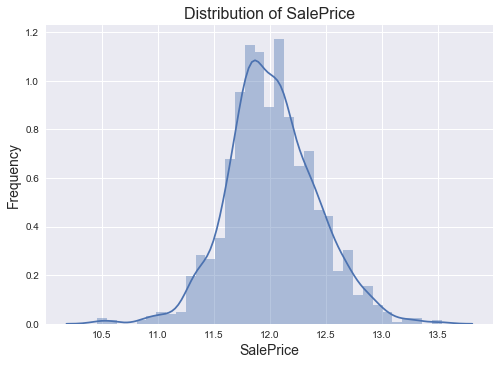

In [14]:
# Apply log(1 + x) to every value of 'SalePrice'
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

# Plot distribution plot again
plt.style.use('seaborn')
sns.distplot(df_train['SalePrice'])
plt.xlabel('SalePrice', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of SalePrice', fontsize=16);

Now that `SalePrice` is normally distributed, I will move on to deal with missing values.

#### 1.2 Missing values

I will check how many missing values we have in the training and test sets.

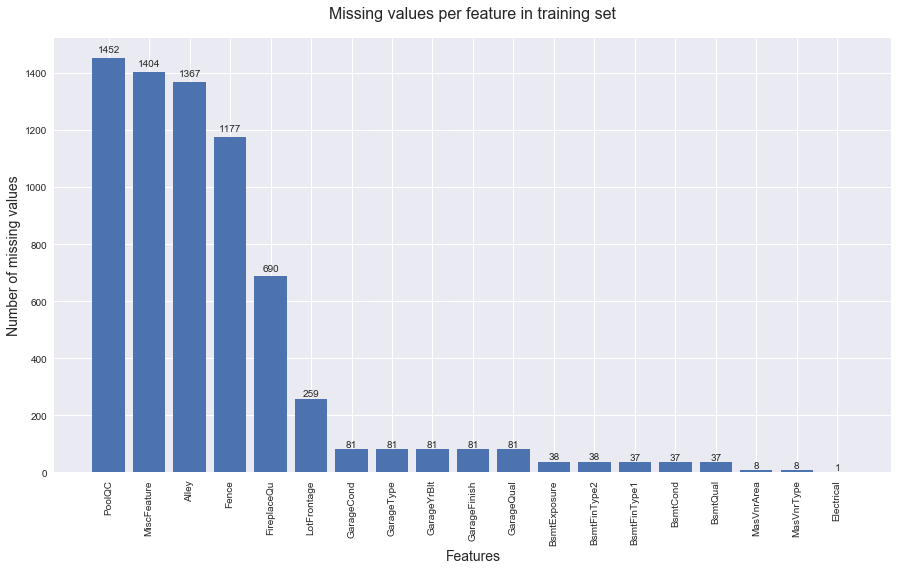

In [15]:
# Create function to plot missing values per feature
def plot_missing_values(df, dataset, num_features):
    plt.figure(figsize=(15, 8))
    sorted_train = df.isna().sum().sort_values(ascending=False)[:num_features]
    bars = plt.bar(sorted_train.index, sorted_train)
    plt.xticks(rotation=90)
    plt.ylabel('Number of missing values', fontsize=14)
    plt.xlabel('Features', fontsize=14)
    plt.title(f'Missing values per feature in {dataset} set', fontsize=16, y=1.03);

    # Plot value for each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2,
                 1.01 * height, 
                 '%d' % int(height),
                 ha='center', 
                 va='bottom')

# Plot missing values for training set
plot_missing_values(df_train, 'training', 19)

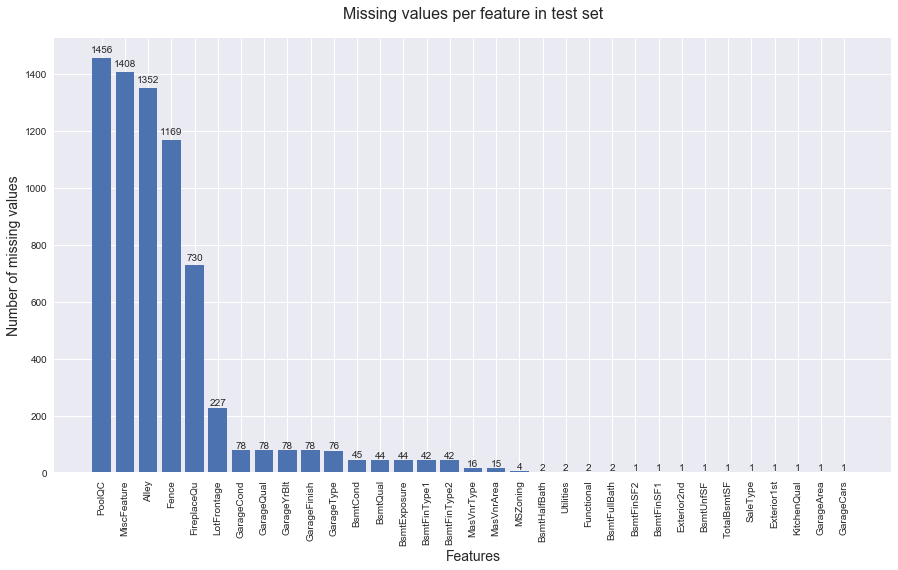

In [16]:
# Plot missing values for test set
pd.set_option('display.max_rows', None)
plot_missing_values(df_test, 'test', 33)

In both sets, `Alley`, `PoolQC`, `Fence` and `MiscFeature` have most of the values missing. `Lot frontage`, `FireplaceQu` also have a high number of missing values and then there are several variables with a small amount of missing values.

#### 1.2.1 Values considered missing incorrectly 

The following variables have "missing values" in the training and test sets:
   * Alley
   * BsmtQual    
   * BsmtCond
   * BsmtExposure  
   * BsmtFinType1  
   * BsmtFinType2
   * FireplaceQu
   * GarageType
   * GarageYrBlt
   * GarageFinish
   * GarageQual
   * GarageCond
   * PoolQc
   * Fence
   * MiscFeature    

After checking the data dictionary and the csv files, I see that these variables have a value for when the characteristic in question doesn't exist, which is 'NA'.
When importing the files, I believe Pandas has interpreted these values as NAN and that is why there are missing values in these variables.

The 5 variables that refer to the garage have almost the same number of missing values but there are some slight differences. The same happens for the 5 variables that refer to the basement. I will check these 2 groups of 5 variables further to make sure that I fill some missing values with the proper value and then fill the rest with 'NA'.

The other variables I will fill the missing values with the string 'NA'.

**Alley**

In [17]:
# Check how many unique values this variable has
print('Training set:')
print(df_train['Alley'].value_counts())
print('\nTest set:')
print(df_test['Alley'].value_counts())

Training set:
Grvl    50
Pave    41
Name: Alley, dtype: int64

Test set:
Grvl    70
Pave    37
Name: Alley, dtype: int64


**PoolQC**

In [18]:
# Check how many unique values this variable has compared to 'PoolArea' in training set
print('Training set:\n')
print(df_train['PoolArea'].value_counts())
print('\n')
print(df_train['PoolQC'].value_counts())

Training set:

0      1452
738       1
648       1
576       1
555       1
519       1
512       1
Name: PoolArea, dtype: int64


Fa    2
Ex    2
Gd    2
Name: PoolQC, dtype: int64


In [19]:
# Check how many unique values this variable has compared to 'PoolArea' in test set
print('Test set:\n')
print(df_test['PoolArea'].value_counts())
print('\n')
print(df_test['PoolQC'].value_counts())

Test set:

0      1453
800       1
561       1
444       1
368       1
228       1
144       1
Name: PoolArea, dtype: int64


Ex    2
Gd    1
Name: PoolQC, dtype: int64


For the training set, all the values of `PoolArea` above zero seem to have a corresponding value in the variable `PoolQc`. For the test set, `PoolArea` has some values that are above zero but for some of them `PoolQc` doesn't have a corresponding value so I will have to check these two variables further.

In [20]:
# Check correspondence between the values above zero in 'PoolArea' and 'PoolQC' in the training set
df_train.groupby(['PoolArea'])['PoolQC'].value_counts()

PoolArea  PoolQC
512       Ex        1
519       Fa        1
555       Ex        1
576       Gd        1
648       Fa        1
738       Gd        1
Name: PoolQC, dtype: int64

In [21]:
# Check correspondence between the values above zero in 'PoolArea' and 'PoolQC' in the test set
df_test.groupby(['PoolArea'])['PoolQC'].value_counts()

PoolArea  PoolQC
144       Ex        1
228       Ex        1
800       Gd        1
Name: PoolQC, dtype: int64

I can clearly see that, in the test set, there are 3 values above zero of the `PoolArea` variable that don't have a corresponding value. To fill these missing values, I will take the following approach:
* Compute the mean of the `PoolArea` variable under each category of `PoolQC`
* Check the `PoolArea` value for the 3 missing values in `PoolQC`
* Take the `PoolArea` values and compare them to the mean values for each category in `PoolQC`.
* Replace missing values with category of `PoolQC` whose value of `PoolArea` is closest to the mean of that category

In [22]:
# Join train and test sets so that I can consider all values of 'PoolArea' above zero, since they are so few
joined_train_test = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Group data by 'PoolQC' and take the mean of 'PoolArea' for each category
mean_poolArea = joined_train_test.groupby(['PoolQC'])['PoolArea'].mean()
mean_poolArea

PoolQC
Ex    359.750000
Fa    583.500000
Gd    704.666667
Name: PoolArea, dtype: float64

In [23]:
# Get indices of the 3 missing values in 'PoolQC'
set(df_test[df_test['PoolArea'] > 0].index) - set(df_test[df_test['PoolQC'].notnull()].index)

{960, 1043, 1139}

In [24]:
# Check 'PoolArea' values for the 3 missing values
df_test['PoolArea'][[960, 1043, 1139]]

960     368
1043    444
1139    561
Name: PoolArea, dtype: int64

In [25]:
# Fill missing values
df_test.loc[960, 'PoolQC'] = 'Ex'
df_test.loc[1043, 'PoolQC'] = 'Ex'
df_test.loc[1139, 'PoolQC'] = 'Fa'

# Check if missing values were filled
df_test['PoolQC'].value_counts()

Ex    4
Fa    1
Gd    1
Name: PoolQC, dtype: int64

**Fence**

In [26]:
# Check how many unique values this variable has
print('Training set:')
print(df_train['Fence'].value_counts())
print('\nTest set:')
print(df_test['Fence'].value_counts())

Training set:
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

Test set:
MnPrv    172
GdPrv     59
GdWo      58
MnWw       1
Name: Fence, dtype: int64


**MiscFeature**

In [27]:
# Check how many unique values this variable has
print('Training set:')
print(df_train['MiscFeature'].value_counts())
print('\nTest set:')
print(df_test['MiscFeature'].value_counts())

Training set:
Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

Test set:
Shed    46
Gar2     3
Othr     2
Name: MiscFeature, dtype: int64


**FireplaceQu**

In [28]:
# Check how many unique values this variable has
print('Training set:')
print(df_train['FireplaceQu'].value_counts())
print('\nTest set:')
print(df_test['FireplaceQu'].value_counts())

Training set:
Gd    378
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

Test set:
Gd    364
TA    279
Fa     41
Po     26
Ex     19
Name: FireplaceQu, dtype: int64


In the missing values plots, we saw that `FireplaceQu` had 690 missing values in the training set and 730 missing values in the test set. Since this variable is related to the variable `Fireplaces`, which indicates how many fireplaces there are in the house, I will check if the missing values in `FireplaceQu`correspond to the value zero in `Fireplaces`.

In [29]:
print('Training set:')
print(df_train['Fireplaces'].value_counts())
print('\nTest set:')
print(df_test['Fireplaces'].value_counts())

Training set:
0    690
1    649
2    115
3      4
Name: Fireplaces, dtype: int64

Test set:
0    730
1    618
2    104
3      6
4      1
Name: Fireplaces, dtype: int64


As we can see the missing values in `FireplaceQu` correspond to when the value of `Fireplace` is equal to 0.

**Garage variables**

In [30]:
# Check if the 5 variables have missing values in the same indices for training set
df_train[df_train['GarageType'].isnull()][['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual','GarageCond']]

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN
140,NaN,NaN,NaN,NaN,NaN


In [31]:
# Check if the 5 variables have missing values in the same indices for test set
df_test[df_test['GarageCond'].isnull()][['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual','GarageCond']]

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
53,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN
130,NaN,NaN,NaN,NaN,NaN
133,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN


We can see that in the training set, the 5 variables have missing values in the same indices so I can fill the values with 'NA'. In the test set we see that `GarageType` has 2 values that are not missing but the other variables have a missing value in these indices. 

Given that for these 2 garages, there is no more information, it means that either the garage wasn't verified or a mistake was made and these houses don't have garages. I will consider the latter and set these 2 values to 'NA'.

In [32]:
# Set values to 'NA'
df_test.loc[666, 'GarageType'] = 'NA'
df_test.loc[1116, 'GarageType'] = 'NA'

**Basement variables**

*Training set:*

After working with these variables for a bit, I verified that 2 of them have only 1 missing value that is unique to them. As such, I will apply this approach:
* Find the indices for these missing values
* Group the data by the 5 variables and check the mode value for each combination of values
* Fill these missing values with the corresponding mode value

In [33]:
# Get indices of houses that have a missing value in 'BsmtExposure'
set(df_train[df_train['BsmtExposure'].isnull()].index) - set(df_train[df_train['BsmtCond'].isnull()].index)

{948}

In [34]:
# Get indices of houses that have a missing value in 'BsmtFinType2'
set(df_train[df_train['BsmtFinType2'].isnull()].index) - set(df_train[df_train['BsmtCond'].isnull()].index)

{332}

In [35]:
# Check these indices for the 5 variables
df_train.loc[[332, 948], ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
332,Gd,TA,No,GLQ,NaN
948,Gd,TA,NaN,Unf,Unf


In [36]:
# Check how many unique values we have in 'BsmtFinType2' for this combination of values
df_train[(df_train['BsmtQual'] == 'Gd') & (df_train['BsmtCond'] == 'TA') & (df_train['BsmtExposure'] == 'No')
        & (df_train['BsmtFinType1'] == 'GLQ')]['BsmtFinType2'].value_counts()

Unf    126
LwQ      1
Rec      1
Name: BsmtFinType2, dtype: int64

In [37]:
# Check how many unique values we have in 'BsmtExposure' for this combination of values
df_train[(df_train['BsmtQual'] == 'Gd') & (df_train['BsmtCond'] == 'TA') & (df_train['BsmtFinType1'] == 'Unf')
        & (df_train['BsmtFinType2'] == 'Unf')]['BsmtExposure'].value_counts()

No    136
Av     26
Mn     10
Gd      5
Name: BsmtExposure, dtype: int64

I will fill these two missing values with the corresponding mode value.

In [38]:
df_train.loc[332, 'BsmtFinType2'] = 'Unf'
df_train.loc[948, 'BsmtExposure'] = 'No'

*Test set:*

After working with these variables for a bit, I verified that 3 of them have some missing values that are unique to them. As such, I will apply this approach:
* Find the indices for these missing values
* Group the data by the 5 variables and check the mode value for each combination of values
* Fill these missing values with the corresponding mode value

In [39]:
# Get indices of houses that have a missing value in 'BsmtCond'
set(df_test[df_test['BsmtCond'].isnull()].index) - set(df_test[df_test['BsmtQual'].isnull()].index)

{580, 725, 1064}

In [40]:
# Get indices of houses that have a missing value in 'BsmtQual'
set(df_test[df_test['BsmtQual'].isnull()].index) - set(df_test[df_test['BsmtCond'].isnull()].index)

{757, 758}

In [41]:
set(df_test[df_test['BsmtExposure'].isnull()].index) - set(df_test[df_test['BsmtCond'].isnull()].index)

{27, 888}

In [42]:
# Check these indices for the 5 variables
df_test.loc[[27, 580, 725, 757, 758, 888, 1064], ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
27,Gd,TA,NaN,Unf,Unf
580,Gd,NaN,Mn,GLQ,Rec
725,TA,NaN,No,BLQ,Unf
757,NaN,Fa,No,Unf,Unf
758,NaN,TA,No,Unf,Unf
888,Gd,TA,NaN,Unf,Unf
1064,TA,NaN,Av,ALQ,Unf


In [43]:
# Check how many unique values we have in 'BsmtQual' for this combination of values
df_test[(df_test['BsmtCond'] == 'Fa') & (df_test['BsmtExposure'] == 'No') & (df_test['BsmtFinType1'] == 'Unf')
        & (df_test['BsmtFinType2'] == 'Unf')]['BsmtQual'].value_counts()

TA    15
Fa     8
Gd     1
Name: BsmtQual, dtype: int64

In [44]:
# Check how many unique values we have in 'BsmtQual' for this combination of values
df_test[(df_test['BsmtCond'] == 'TA') & (df_test['BsmtExposure'] == 'No') & (df_test['BsmtFinType1'] == 'Unf')
        & (df_test['BsmtFinType2'] == 'Unf')]['BsmtQual'].value_counts()

TA    156
Gd    119
Fa     21
Ex      9
Name: BsmtQual, dtype: int64

Given that the mode value for both combinations is 'TA', I will fill these two values of `BsmtQual` with 'TA'.

In [45]:
df_test.loc[[757, 758], 'BsmtQual'] = 'TA'

 Now I will move on to `BsmtCond`.

In [46]:
# Check how many unique values we have in 'BsmtCond' for this combination of values
df_test[(df_test['BsmtQual'] == 'Gd') & (df_test['BsmtExposure'] == 'Mn') & (df_test['BsmtFinType1'] == 'GLQ')
        & (df_test['BsmtFinType2'] == 'Rec')]['BsmtCond'].value_counts()

TA    1
Name: BsmtCond, dtype: int64

In [47]:
# Check how many unique values we have in 'BsmtCond' for this combination of values
df_test[(df_test['BsmtQual'] == 'TA') & (df_test['BsmtExposure'] == 'No') & (df_test['BsmtFinType1'] == 'BLQ')
        & (df_test['BsmtFinType2'] == 'Unf')]['BsmtCond'].value_counts()

TA    53
Fa     4
Name: BsmtCond, dtype: int64

In [48]:
# Check how many unique values we have in 'BsmtCond' for this combination of values
df_test[(df_test['BsmtQual'] == 'TA') & (df_test['BsmtExposure'] == 'Av') & (df_test['BsmtFinType1'] == 'ALQ')
        & (df_test['BsmtFinType2'] == 'Unf')]['BsmtCond'].value_counts()

TA    14
Name: BsmtCond, dtype: int64

Once again the mode value for the three combinations is 'TA'. As such, I will fill these three values of `BsmtCond` with 'TA'.

In [49]:
df_test.loc[[580, 725, 1064], 'BsmtCond'] = 'TA'

Now I will move on to `BsmtExposure`.

In [50]:
# Check how many unique values we have in 'BsmtExposure' for this combination of values
df_test[(df_test['BsmtQual'] == 'Gd') & (df_test['BsmtCond'] == 'TA') & (df_test['BsmtFinType1'] == 'Unf')
        & (df_test['BsmtFinType2'] == 'Unf')]['BsmtExposure'].value_counts()

No    119
Av     32
Mn     12
Gd      5
Name: BsmtExposure, dtype: int64

The mode value here is 'No' and as such I will fill the 2 missing values in this variable with 'No'.

In [51]:
df_test.loc[[27, 888], 'BsmtExposure']  = 'No'

**Fill missing values with 'NA'**

After having properly filled some missing values, I can now fill the rest of missing values with 'NA'.

In [52]:
def fill_na_values(df):
    df['Alley'].fillna('NA', inplace=True)
    df['PoolQC'].fillna('NA', inplace=True)
    df['Fence'].fillna('NA', inplace=True)
    df['MiscFeature'].fillna('NA', inplace=True)
    df['FireplaceQu'].fillna('NA', inplace=True)
    df['GarageType'].fillna('NA', inplace=True)
    df['GarageYrBlt'].fillna(0, inplace=True)
    df['GarageFinish'].fillna('NA', inplace=True)
    df['GarageQual'].fillna('NA', inplace=True)
    df['GarageCond'].fillna('NA', inplace=True)
    df['BsmtQual'].fillna('NA', inplace=True)
    df['BsmtCond'].fillna('NA', inplace=True)
    df['BsmtExposure'].fillna('NA', inplace=True)
    df['BsmtFinType1'].fillna('NA', inplace=True)
    df['BsmtFinType2'].fillna('NA', inplace=True)

    return df

df_train = fill_na_values(df_train)
df_test = fill_na_values(df_test)

#### 1.2.2 MasVnrType and MasVnrArea

*Training set:*

These variables have only 8 missing values each. I will check if they have missing values in the same indices and if so fill them with the corresponding mode value.

In [53]:
# Check if the variables have missing values in the same indices
set(df_train[df_train['MasVnrType'].isnull()].index) - set(df_train[df_train['MasVnrArea'].isnull()].index)

set()

In [54]:
# Check how many unique values we have in 'MasVnrType'
df_train['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      126
BrkCmn      15
Name: MasVnrType, dtype: int64

In [55]:
# Check how many unique values we have in 'MasVnrArea'
df_train['MasVnrArea'].value_counts()

0.0       861
72.0        8
180.0       8
108.0       8
120.0       7
16.0        7
80.0        6
200.0       6
106.0       6
340.0       6
170.0       5
132.0       5
360.0       5
84.0        5
320.0       5
100.0       4
196.0       4
246.0       4
216.0       4
160.0       4
183.0       4
178.0       4
270.0       4
300.0       4
210.0       4
268.0       4
252.0       4
168.0       4
336.0       4
220.0       4
76.0        4
288.0       4
456.0       4
40.0        4
50.0        3
130.0       3
82.0        3
208.0       3
90.0        3
70.0        3
44.0        3
420.0       3
99.0        3
110.0       3
104.0       3
85.0        3
272.0       3
226.0       3
174.0       3
240.0       3
186.0       3
169.0       3
148.0       3
350.0       3
128.0       3
176.0       3
166.0       3
116.0       3
136.0       3
312.0       3
256.0       3
145.0       3
74.0        3
42.0        3
98.0        2
66.0        2
660.0       2
243.0       2
338.0       2
143.0       2
285.0       2
289.0 

In [56]:
# Fill missing values with mode value of each variable
df_train['MasVnrType'].fillna('None', inplace=True)
df_train['MasVnrArea'].fillna(0.0, inplace=True)

Test set:

`MasVnrType` has one more missing value than `MasVnrArea`. I will check this missing value and fill it first with the appropriate value. After I will fill the remaining missing values with the corresponding mode value.

In [57]:
# Check if the variables have missing values in the same indices
set(df_test[df_test['MasVnrType'].isnull()].index) - set(df_test[df_test['MasVnrArea'].isnull()].index)

{1150}

After checking the data dictionary, I think that `Exterior1st` and `Exterior2nd` are related to these variables since they refer to the material used for the covering of the house. Using these 2 variables, I will check how many unique values we have for `MasVnrType`.

In [58]:
# Check house with missing value that only exists in 'MasVnrType'
df_test.loc[1150, ['Exterior1st', 'Exterior2nd', 'MasVnrArea', 'MasVnrType']]

Exterior1st    Plywood
Exterior2nd    Plywood
MasVnrArea         198
MasVnrType         NaN
Name: 1150, dtype: object

In [59]:
# Check how many unique values we have using the variables' values of the house in question
df_test[(df_test['Exterior1st'] == 'Plywood') & (df_test['Exterior2nd'] == 'Plywood')]['MasVnrType'].value_counts()

None       51
BrkFace    30
Stone       6
BrkCmn      2
Name: MasVnrType, dtype: int64

Since we have a value above 0 for `MasVnrArea`, which refers to the area , it makes sense to fill the missing value with 'BrkFace' which is the second most ocurring value following 'None'.

In [60]:
# Fill missing value
df_test.loc[1150, 'MasVnrType'] = 'BrkFace'

Now I can fill the remaining missing values with the mode values of the two variables.

In [61]:
# Check how many unique values we have in 'MasVnrType'
df_test['MasVnrType'].value_counts()

None       878
BrkFace    435
Stone      121
BrkCmn      10
Name: MasVnrType, dtype: int64

In [62]:
# Check how many unique values we have in 'MasVnrArea'
df_test['MasVnrArea'].value_counts()

0.0       877
176.0      10
144.0       9
120.0       8
216.0       8
200.0       7
128.0       6
504.0       6
302.0       6
198.0       6
196.0       5
140.0       5
203.0       5
260.0       5
210.0       5
60.0        5
256.0       5
164.0       5
23.0        4
16.0        4
112.0       4
178.0       4
40.0        4
194.0       4
174.0       4
420.0       4
143.0       4
306.0       4
50.0        4
186.0       4
150.0       4
340.0       4
242.0       4
88.0        4
20.0        4
240.0       4
180.0       4
232.0       4
44.0        4
190.0       3
172.0       3
300.0       3
108.0       3
76.0        3
68.0        3
72.0        3
52.0        3
248.0       3
145.0       3
126.0       3
456.0       3
90.0        3
182.0       3
162.0       3
32.0        3
513.0       3
130.0       3
80.0        3
96.0        3
264.0       3
270.0       3
132.0       3
280.0       3
252.0       3
170.0       3
98.0        3
14.0        3
450.0       3
206.0       3
246.0       2
84.0        2
218.0 

In [63]:
# Fill missing values with mode value of each variable
df_test['MasVnrType'].fillna('None', inplace=True)
df_test['MasVnrArea'].fillna(0.0, inplace=True)

#### 1.2.3 Electrical

For this variable we only have 1 missing value in the training set. As such, I will fill it with the mode value.

In [64]:
# Check how many unique values we have
df_train['Electrical'].value_counts()

SBrkr    1332
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [65]:
# Fill missing value
df_train['Electrical'].fillna('SBrkr', inplace=True)

#### 1.2.4 Lot Frontage

Filling the missing values in this variable using the median value for the variable or other descriptive statistic measures doesn't make much sense. As such, after doing some research, I found that grouping the houses by the `Neighborhood` variable and filling the missing values with the median of the neighborhood's `Lot Frontage` is a reasonable idea, since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood.

In [66]:
# Fill missing values
df_train['LotFrontage'] = df_train.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_test['LotFrontage'] = df_test.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Now all that is left is to fill the missing values that remain in the test set. All these variables have only 1 or 2 missing values so I will fill them all the same way, which is by using the mode value.

#### 1.2.5 Remaining missing values in test set

The remaining variables with missing values are:

* GarageCars
* GarageArea
* SaleType
* Functional
* KitchenQual
* BsmtFullBath
* BsmtHalfBath
* BsmtFinSF1
* BsmtFinSF2
* BsmtUnfSF
* TotalBsmtSF
* Exterior1st
* Exterior2nd
* MSZoning           
* Utilities

**GarageCars and GarageArea**

In [67]:
# Check what values the other Garage related variables have in the example with missing values
df_test[df_test['GarageArea'].isnull()][['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
                                         'GarageCond', 'GarageArea', 'GarageCars']]

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,GarageArea,GarageCars
1116,NA,0.0,NA,NA,NA,NaN,NaN


Given that the other garage related variables have all 'NA', I will fill the missing values with the value 0.0.

In [68]:
# Fill missing values
df_test['GarageCars'].fillna(0.0, inplace=True)
df_test['GarageArea'].fillna(0.0, inplace=True)

**BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath**

These variables are related to each other and so I will check them together.

In [69]:
df_test[df_test['BsmtHalfBath'].isnull()][['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                                           'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 
                                           'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
660,NA,NA,NA,NA,NaN,NA,NaN,NaN,NaN,NaN,NaN
728,NA,NA,NA,NA,0.0,NA,0.0,0.0,0.0,NaN,NaN


As we can see other basement related variables have 'NA' as their value and so I will fill the missing value in these 3 variables with 0.0.

In [70]:
# Fill missing values
df_test['BsmtFinSF1'].fillna(0.0, inplace=True)
df_test['BsmtFinSF2'].fillna(0.0, inplace=True)
df_test['BsmtUnfSF'].fillna(0.0, inplace=True)
df_test['TotalBsmtSF'].fillna(0.0, inplace=True)
df_test['BsmtFullBath'].fillna(0.0, inplace=True)
df_test['BsmtHalfBath'].fillna(0.0, inplace=True)

**MSZoning**

I will fill the missing values in this variable with the mode value of `MSZoning` by the different categories in `MSSubClass`. This is because the type of house is likely linked to the general zoning classification.

In [71]:
df_test['MSZoning'] = df_test.groupby(['MSSubClass'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

**Remaining variables**

I will fill these variables with the mode value.

In [72]:
# Fill missing values
df_test['SaleType'].fillna(df_test['SaleType'].mode()[0], inplace=True)
df_test['Functional'].fillna(df_test['Functional'].mode()[0], inplace=True)
df_test['KitchenQual'].fillna(df_test['KitchenQual'].mode()[0], inplace=True)
df_test['Exterior1st'].fillna(df_test['Exterior1st'].mode()[0], inplace=True)
df_test['Exterior2nd'].fillna(df_test['Exterior2nd'].mode()[0], inplace=True)
df_test['Utilities'].fillna(df_test['Utilities'].mode()[0], inplace=True)

In [73]:
# Check if there are any missing values left in training set
df_train.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr

In [74]:
# Check if there are any missing values left in test set
df_test.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr

#### 1.3 Feature Engineering

I will start by creating some new features based on the existing ones.

#### 1.3.1 Creating new features

I will create the following features:
* TotalSF - Total square feet of living area above and below ground
* TotalPorchArea - Total area of porches in the house
* TotalBathrooms - Total amount of bathrooms (basement and above ground)
* HouseAge - Age of the house up until the year that it was sold. If the house was remodeled than that will be considered as year that it was built
* Remodeled - Indicates if the house was remodeled or not. This should be seen as some sort of penalty parameter that indicates that if the HouseAge is based on a remodeling date, it is probably worth less than houses that were built from scratch in that same year.
* isNew - Indicates if the house was built and sold in the same year (considered new)

In [75]:
def create_features(df):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalPorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df['TotalBathrooms'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
    df['HouseAge'] = df['YrSold'] - df['YearRemodAdd']
    df['Remodeled'] = np.where(df['YearBuilt'] == df['YearRemodAdd'], 1, 0)
    df['isNew'] = np.where(df['YearBuilt'] == df['YrSold'], 1, 0)

# Create features in training and test sets
create_features(df_train)
create_features(df_test)

#### 1.3.2 Skewed features

I will check if the numerical features are skewed and if so I will normalize them using a box cox transformation of 1 + x. I will join the training and the test sets so that the same variables are normalized.

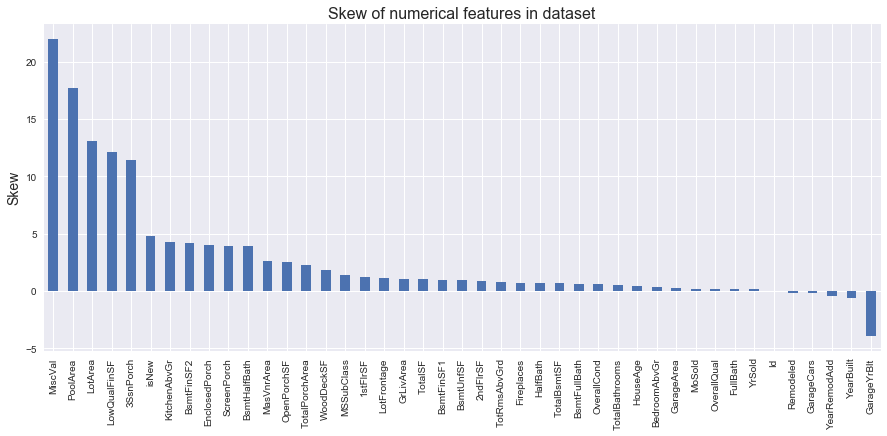

In [76]:
def skewness(df):
    # Get labels of numerical features
    numeric_features = df.dtypes[df.dtypes != 'object'].index

    # Check the skew of all numerical features
    skewed_features = df[numeric_features].skew().sort_values(ascending=False)
    df_skew = pd.DataFrame(skewed_features, columns=['Skew'])

    # Plot skew
    df_skew.plot.bar(legend=None, figsize=(15, 6))
    plt.ylabel('Skew', fontsize=14)
    plt.title(f'Skew of numerical features in dataset', fontsize=16);
    
    # Get all variables with skewness above 0.5 or below -0.5
    df_skew = df_skew[abs(df_skew) > 0.5].dropna()
    df_skew = df_skew.drop('isNew')

    # Box cox transform
    skewed_indices = df_skew.index
    lambda_ = 0.15
    for feature in skewed_indices:
        df[feature] = boxcox1p(df[feature], lambda_)

# Remove 'SalePrice' from DataFrame and store it in another variable
df = df_train.drop('SalePrice', axis=1)
saleprice = df_train['SalePrice']

# Joined datasets
datasets = pd.concat([df, df_test], ignore_index=True)

skewness(datasets)

#### 1.3.3 Turn numerical features into categorical features

There are a few numerical features that in reality are categorical. Some are already in a scale of 1 to something and their values should have some sort of ranking. But there are 3 variables that their values shouldn't have any kind of ranking and so I will turn them into categorical variablesin order to one hot encode them. The 3 variables are the following:
* MSSubClass
* OverallQual
* OverallCond
* MoSold
* YrSold

`MSSubClass` has numeric values that are categories but they don't have any relationship between them so I will one hot encode it afterwards. Since this dataset only has a span of 5 years of sales, `YrSold` can be considered a categorical variable and `MoSold` refers to the months so it is also categorical. Both these variables will be one hot encoded afterwards given that their values don't have a ranking, e.g. December is not 'better' than January.

In [77]:
def turn_num_into_cat(df):
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    
turn_num_into_cat(datasets)

#### 1.3.4 Label and One Hot Encoding

As the final step of this EDA, I will label and one hot encode the categorical variables in order to move on to modelling.
I will join both datasets to make sure that both have the same amount of columns, given that there is a possibility that some values might not exist in the test set and one hot encoding will create a discrepancy of columns.

In [78]:
def encoding(df):
    # Label encoding
    label_columns = ('ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
               'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
               'GarageQual', 'GarageCond', 'PoolQC', 'Fence')
    
    for column in label_columns:
        label = LabelEncoder() 
        label.fit(list(df[column].values)) 
        df[column] = label.transform(list(df[column].values))
    
    # Turn variable datatype to integer
    df['GarageYrBlt'] = df['GarageYrBlt'].astype(int)
    
    # One hot encoding
    one_hot_columns = df.dtypes[df.dtypes == 'object'].index
    df[one_hot_columns] = df[one_hot_columns].astype('category')
    df = pd.get_dummies(df)
    
    return df

# Variable encoding
df_encoded = encoding(datasets)

I will delete the `ID` column since it doen't have any significance.

In [79]:
# Drop 'Id' column
df_encoded.drop('Id', axis=1, inplace=True)

# Split encoded DataFrame into training and test sets
train = df_encoded.loc[:1457, :]
test = df_encoded.loc[1458:, :]

# Check dimensions of training and test sets
train.shape, test.shape

((1458, 268), (1459, 268))

### 2. Modelling

Since this is a regression problem, I will train the following models:
* Linear Regression
* Ridge Regression
* Lasso Regression
* Elastic Net Regression
* Stochastic Gradient Descent
* Support Vector Machine (Gaussian kernel)
* Random Forest

#### 2.1 Baseline models

In [80]:
# Assign data to X and y
X = train
y = saleprice

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# Create a dictionary with all the models that I will use
models = {'Linear Regression': LinearRegression(),
          'Ridge Regression': Ridge(),
          'Lasso Regression': Lasso(),
          'Elastic Net Regression': ElasticNet(),
          'Gaussian SVM': SVR(),
          'Random Forest': RandomForestRegressor(),
          'Gradient Boosting': GradientBoostingRegressor(),
          'XGBoost': xgb.XGBRegressor(),
          'LightGBM': lgb.LGBMRegressor()}

# Evaluation function
def evaluate_model(models):
    
    # Set random seed
    np.random.seed(37)
    
    # Initialize variables
    results = dict()
    model_names = []
    
    for model_name, model in models.items():        
        # Evaluation metric
        rmse = np.mean(cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error'))
        
        # Append rmse score to model key
        results[model_name] = rmse
        
        # Append model name
        model_names.append(model_name)
        
    # Create DataFrame with the results
    results_df = pd.DataFrame(results.values(), index=results.keys(), columns=['RMSE'])
        
    return results_df

# View results
results_df = evaluate_model(models)
results_df

,RMSE
Linear Regression,-0.125852
Ridge Regression,-0.119342
Lasso Regression,-0.273140
Elastic Net Regression,-0.269631
Gaussian SVM,-0.273487
Random Forest,-0.137213
Gradient Boosting,-0.121643
XGBoost,-0.131097
LightGBM,-0.127414


Looking at the RMSE score, I am already getting pretty good results from these baseline models. I will drop the Lasso and Elastic Net Regression models and SVM model since these perform the worst on this data and I will proceed with hyperparameter tuning of the remaining models.

#### 2.2 Hyperparameter tuning

I will use RandomizedSearchCV to find the best hyperparameters for each model

In [81]:
# Hyperparameter grid for LightGBM model
lightgbm_grid = {'num_leaves': np.arange(6, 50, 3), 
                 'min_child_samples': np.arange(100, 500, 50), 
                 'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                 'subsample': [0.6, 0.8, 1.0], 
                 'colsample_bytree': [0.3, 0.4, 0.5 , 0.7],
                 'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                 'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

# Hyperparameter grid for XGBoost model
xgboost_grid = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
                'subsample': [0.6, 0.8, 1.0],
                "min_child_weight": [1, 3, 5, 7],
                "gamma": [0.0, 0.1, 0.2 , 0.3, 0.4],
                "colsample_bytree": [0.3, 0.4, 0.5 , 0.7]}

# Hyperparameter grid for Gradient Boosting model
gb_grid = {'learning_rate': [0.01, 0.1, 1, 10, 100],
           'n_estimators': np.arange(10, 100, 10),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2),
           'max_features': [0.5, 1, 'sqrt', 'auto']}

# Hyperparameter grid for Ridge Regression
ridge_grid = {'alpha': np.arange(1, 20, 0.5)}

# Hyperparameter grid for Random Forest
rf_grid = {'n_estimators': np.arange(10, 100, 10),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2),
           'max_features': [0.5, 1, 'sqrt', 'auto']}



# Instantiate RandomizedSearchCV Random Forest model
rs_rf = RandomizedSearchCV(RandomForestRegressor(),
                           param_distributions=rf_grid,
                           n_iter=200,
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           verbose=True,
                           n_jobs=-1,
                           random_state=37)

# Fit Random Forest model to the data
rs_rf.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [82]:
# Find best hyperparameter combination for Random Forest model
rs_rf.best_params_

{'n_estimators': 70,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'max_depth': None}

In [83]:
# Instantiate RandomizedSearchCV Ridge Regression model
rs_ridge = RandomizedSearchCV(Ridge(),
                              param_distributions=ridge_grid,
                              n_iter=100,
                              scoring='neg_root_mean_squared_error',
                              cv=5,
                              verbose=True,
                              n_jobs=-1,
                              random_state=37)

# Fit Ridge Regression model to the data
rs_ridge.fit(X, y)

C:\Users\Barrozito\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 38 is smaller than n_iter=100. Running 38 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:    2.7s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
       12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
       17.5, 18. , 18.5, 19. , 19.5])},
                   pre_dispatch='2*n_jobs', random_state=37, refit=True,
                   return_train_score=False,
                   scoring='neg_root_mean_squared_error', verbose=True)

In [84]:
# Find best hyperparameter combination for Ridge Regression model
rs_ridge.best_params_

{'alpha': 10.5}

In [85]:
# Instantiate RandomizedSearchCV Gradient Boosting model
rs_gb = RandomizedSearchCV(GradientBoostingRegressor(),
                           param_distributions=gb_grid,
                           n_iter=200,
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           verbose=True,
                           n_jobs=-1,
                           random_state=37)

# Fit Gradient Boosting model to the data
rs_gb.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.2min finished
C:\Users\Barrozito\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:788: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [86]:
# Find best hyperparameter combination for Gradient Boosting model
rs_gb.best_params_

{'n_estimators': 70,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'max_depth': 5,
 'learning_rate': 0.1}

In [87]:
# Instantiate RandomizedSearchCV XGBoost model
rs_xgboost = RandomizedSearchCV(xgb.XGBRegressor(),
                                param_distributions=xgboost_grid,
                                n_iter=200,
                                scoring='neg_root_mean_squared_error',
                                cv=5,
                                verbose=True,
                                n_jobs=-1,
                                random_state=37)

# Fit XGBoost model to the data
rs_xgboost.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                   iid='deprecated', n_iter=200, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                      

In [88]:
# Find best hyperparameter combination for XGBoost model
rs_xgboost.best_params_

{'subsample': 1.0,
 'min_child_weight': 3,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

In [89]:
# Instantiate RandomizedSearchCV LightGBM model
rs_lightgbm = RandomizedSearchCV(lgb.LGBMRegressor(),
                                 param_distributions=lightgbm_grid,
                                 n_iter=200,
                                 scoring='neg_root_mean_squared_error',
                                 cv=5,
                                 verbose=True,
                                 n_jobs=-1,
                                 random_state=37)

# Fit LightGBM model to the data
rs_lightgbm.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   40.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                       

In [90]:
# Find best hyperparameter combination for XGBoost model
rs_lightgbm.best_params_

{'subsample': 0.6,
 'reg_lambda': 1,
 'reg_alpha': 0,
 'num_leaves': 45,
 'min_child_weight': 0.1,
 'min_child_samples': 100,
 'colsample_bytree': 0.3}

In [91]:
# Ridge Regression model with best hyperparameters found
best_ridge = Ridge(alpha=10.5)

# Random Forest model with best hyperparameters found
best_rf = RandomForestRegressor(n_estimators= 70,
                                min_samples_split=8,
                                min_samples_leaf=1,
                                max_features=0.5,
                                max_depth=None,
                                n_jobs=-1)

# Gradient Boosting model with best hyperparameters found
best_gb = GradientBoostingRegressor(n_estimators=70,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    max_features=0.5,
                                    max_depth=5,
                                    learning_rate=0.1)

# XGBoost model with best hyperparameters found
best_xgboost = xgb.XGBRegressor(subsample=1.0,
                                min_child_weight=3,
                                max_depth=3,
                                learning_rate=0.15,
                                gamma=0.0,
                                colsample_bytree=0.4)

# LightGBM model with best hyperparameters found
best_lightgbm = lgb.LGBMRegressor(subsample=0.6,
                                  reg_lambda=1,
                                  reg_alpha=0,
                                  num_leaves=45,
                                  min_child_weight=0.1,
                                  min_child_samples=100,
                                  colsample_bytree=0.3)

# Dictionary with best models
best_models = {'Linear Regression': LinearRegression(),
               'Ridge Regression': best_ridge,
               'Random Forest': best_rf,
               'Gradient Boosting': best_gb,
               'XGBoost': best_xgboost,
               'LightGBM': best_lightgbm}

# View results
best_results_df = evaluate_model(best_models)
best_results_df

,RMSE
Linear Regression,-0.125852
Ridge Regression,-0.115274
Random Forest,-0.133084
Gradient Boosting,-0.121901
XGBoost,-0.118121
LightGBM,-0.133467


In [92]:
# Create DataFrame to compare the RMSE scores
compare_dfs = pd.concat([best_results_df, results_df], axis=1, ignore_index=True)
compare_dfs.columns = ['RMSE', 'Baseline RMSE']
compare_dfs.dropna(inplace=True)

# View DataFrame
compare_dfs

,RMSE,Baseline RMSE
Linear Regression,-0.125852,-0.125852
Ridge Regression,-0.115274,-0.119342
Random Forest,-0.133084,-0.137213
Gradient Boosting,-0.121901,-0.121643
XGBoost,-0.118121,-0.131097
LightGBM,-0.133467,-0.127414


The Linear Regression model doesn't have any hyperparameters that we can adjust so it remains the same. The rest of the models had slight improvements with exception of the Gradient Boosting and LightGBM models which have gotten a slightly worse RMSE score. 

The model that performs the best on this data is the Ridge Regression model and I will make my submission with this model.

#### 2.4 Learning curves

To check if the models fit the data well (not overfitting or underfitting) I will plot learning curves. I will only plot learning curves for the 3 models that perform the best in this dataset.

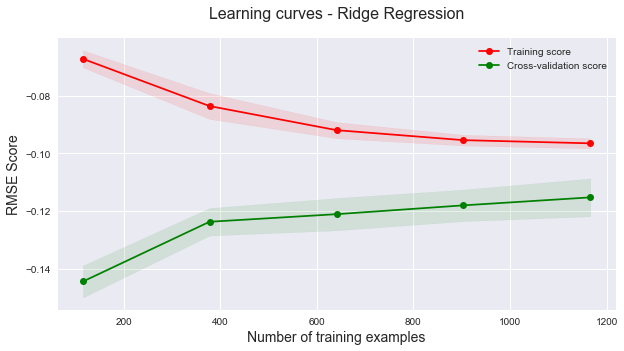

In [93]:
def learning_curves(model, model_name):
    train_sizes, train_scores, validation_scores = \
        learning_curve(model, X, y, cv=5, n_jobs=-1, random_state=37, scoring='neg_root_mean_squared_error')

    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    
    # Plot Learning Curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                         validation_scores_mean + validation_scores_std, alpha=0.1,
                         color="g")
    plt.xlabel('Number of training examples', fontsize=14)
    plt.ylabel('RMSE Score', fontsize=14)
    plt.title(f'Learning curves - {model_name}', fontsize=16, y=1.05)
    plt.legend()
    plt.grid(True);
               
# Ridge Regression learning curves
learning_curves(best_ridge, 'Ridge Regression')

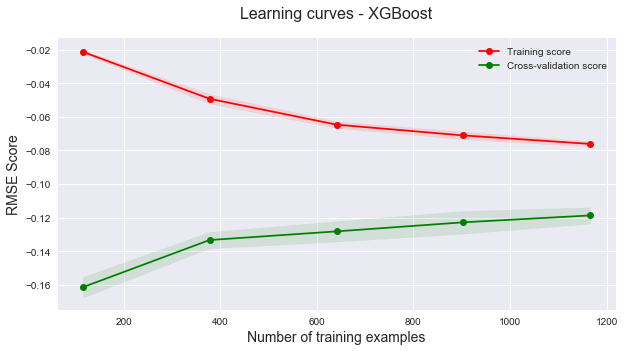

In [94]:
# XGBoost learning curves
learning_curves(best_xgboost, 'XGBoost')

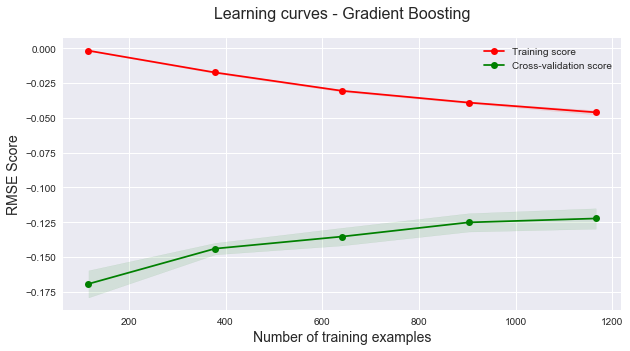

In [95]:
# Gradient Boosting learning curves
learning_curves(best_gb, 'Gradient Boosting')

Ridge Regression model seems to fit the data well given that the training and cross validation scores are close to each other. XGBoost model seems to slightly overfit the data and Gradient Boosting clearly overfits the data. All models seem to benefit from having more samples since they are still converging.

### 2.5 Feature importance

I will check which features contributed the most for the predictions made by the Ridge Regression model.

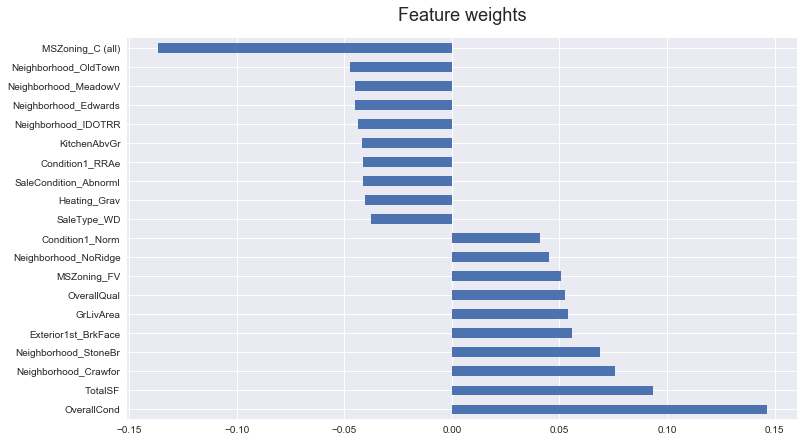

In [122]:
# Fit model to the data
best_ridge.fit(X, y)

# Create Dataframe of the top 20 features' weights
feature_importance_1 = pd.DataFrame(best_ridge.coef_, index=X.columns).sort_values(0, ascending=False)[:10]
feature_importance_2 = pd.DataFrame(best_ridge.coef_, index=X.columns).sort_values(0, ascending=False)[-10:]
feature_importance = pd.concat([feature_importance_1, feature_importance_2])

# Plot bar chart
feature_importance.plot.barh(legend=False, figsize=(12, 7))
plt.title('Feature weights', fontsize=18, y=1.03);

### 3. Submission

The last step is to create a submission file for Kaggle and check how I did in the leaderboard.

In [123]:
# Get original test dataset
test_df = pd.read_csv('Data/test.csv')

# Fit best Ridge Regression model
best_ridge.fit(X, y)

# Make predictions
y_preds = np.expm1(best_ridge.predict(test))

# Create submission DataFrame
submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_preds})

submission.to_csv('submission.csv', index=False)

I managed to get a score of 0.12149 on Kaggle and got a place in the top 1000.